In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import json

In [20]:
def plot_history(log_path="experiments/exp_0", add_title=False):
    _, ax = plt.subplots()
    df_history = pd.read_csv(f"{log_path}/ga_history.csv")
    df_history['cumulative_average'] = df_history['best_cost'].expanding().mean()
    ax.plot(df_history['generation'], df_history['cumulative_average'], label='Cumulative Average of Best Cost')
    ax.plot(df_history['generation']-1, df_history['best_cost'], label='Best Cost per Generation', zorder=5)

    df_evaluations = pd.read_csv(f"{log_path}/ga_evaluations.csv")
    ax.scatter(df_evaluations['generation'], df_evaluations['evaluation_cost'], color='red', alpha=0.2, s=2, label='Offspring Evaluation')

    if add_title:
        json_path = f"{log_path}/ga_params.json"
        with open(json_path, "r") as f:
            params = json.load(f)
        improvement_over_baseline = 1 - (df_history['best_cost'].min() / params["baseline_cost"])
        title = f"n={params['problem_size']}, alpha={params['problem_alpha']}, beta={params['problem_beta']}, density={params['problem_density']:.1f}, i={improvement_over_baseline:.2f}"
        ax.set_title(title)

    ax.set_xlabel('Generation')
    ax.set_ylabel('Cost')
    ax.legend()
    plt.show()
    return ax

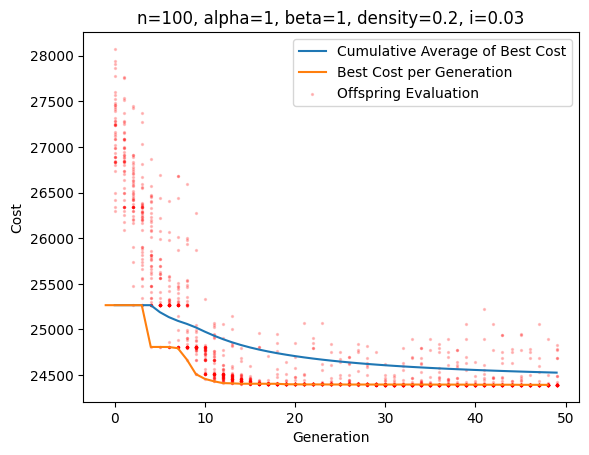

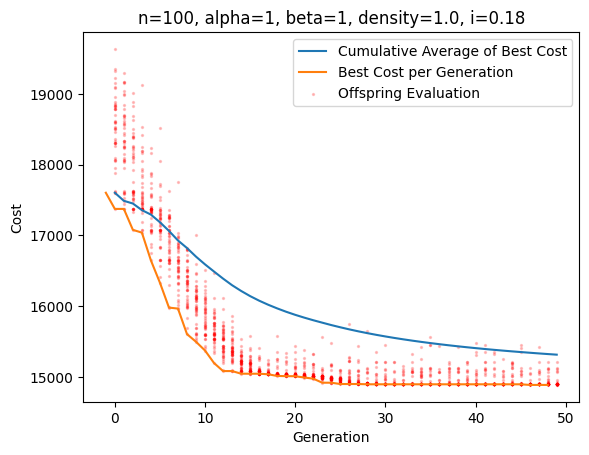

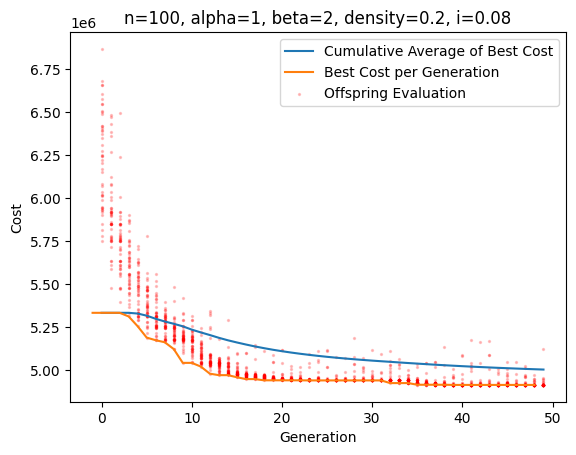

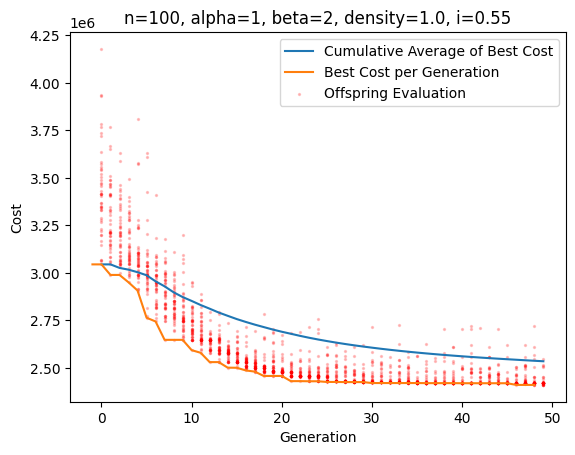

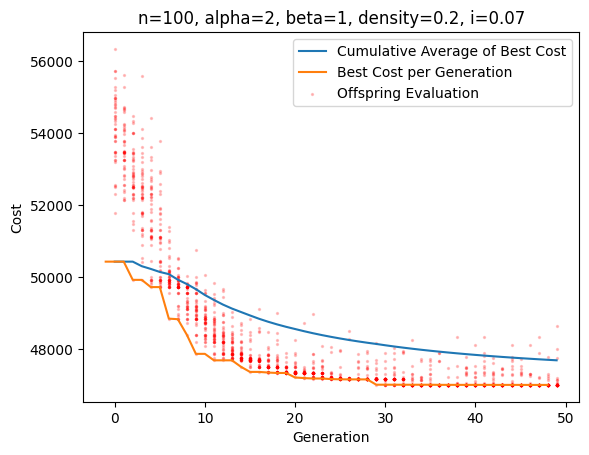

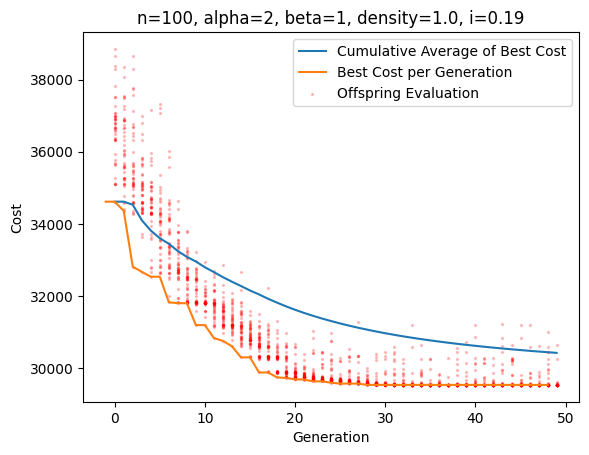

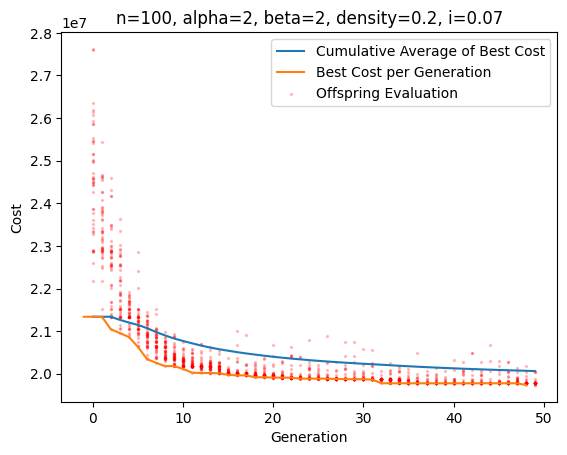

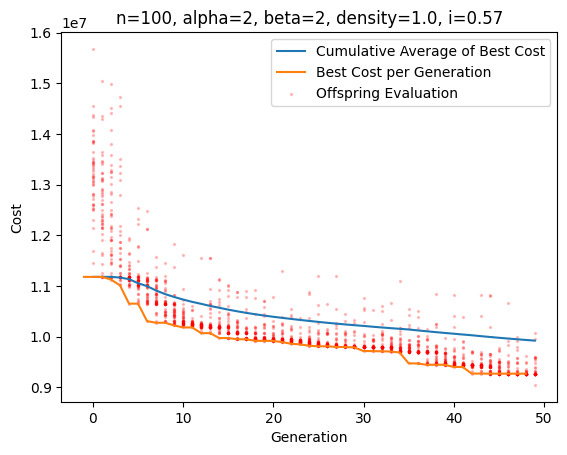

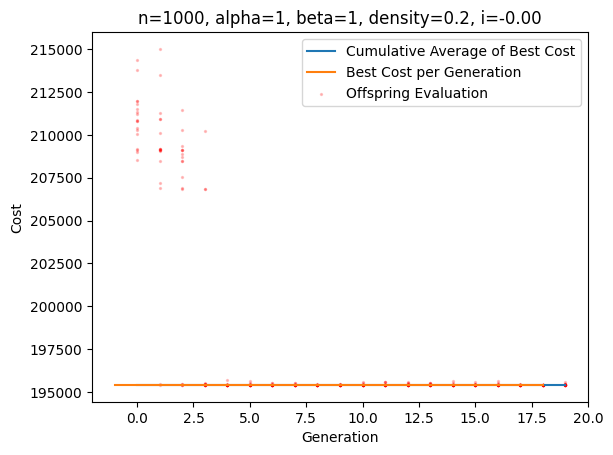

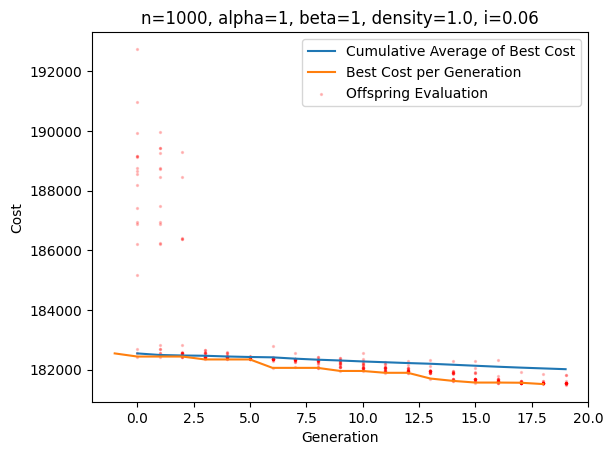

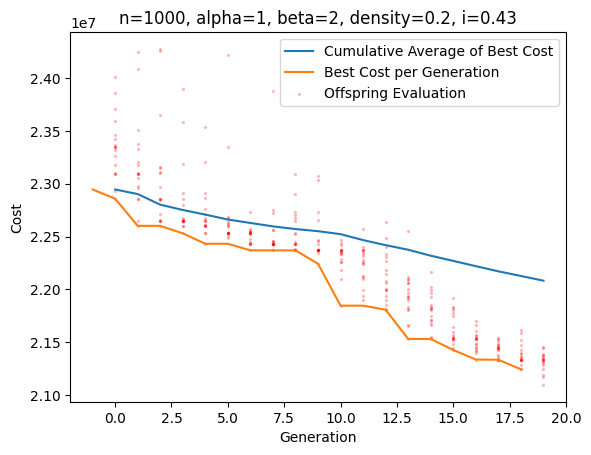

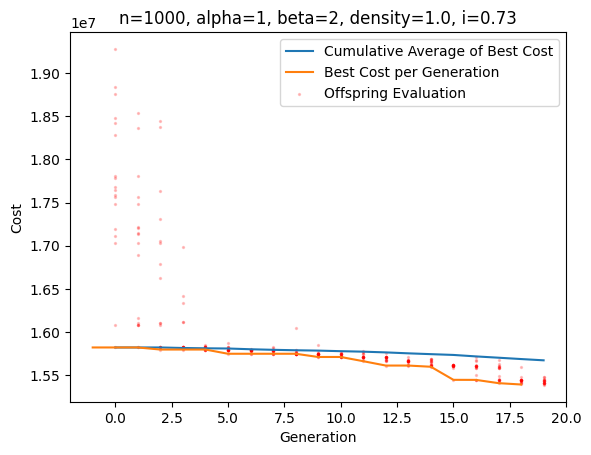

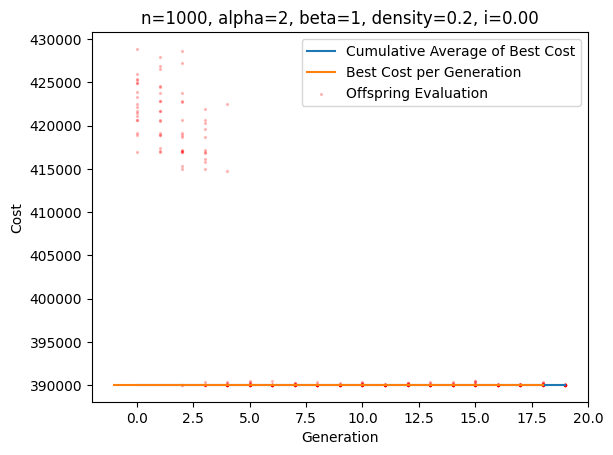

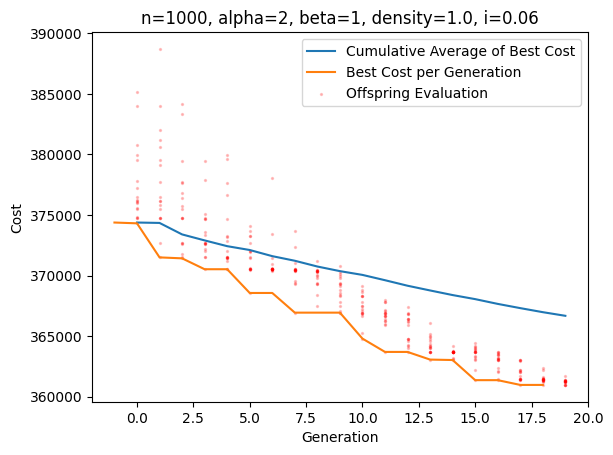

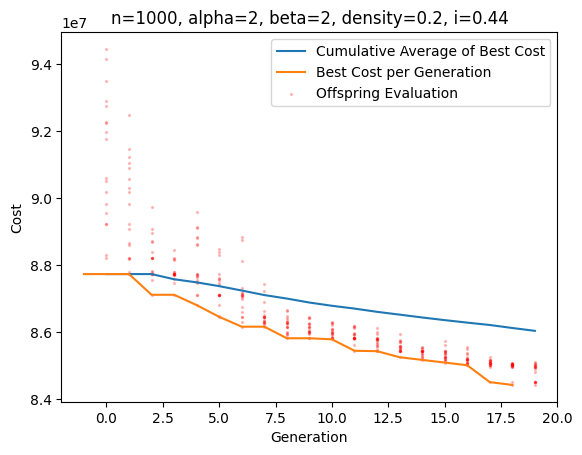

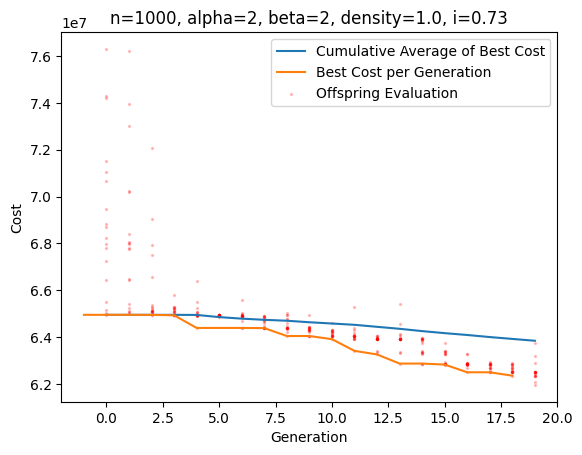

In [21]:
for i in range(16):
    log_dir = f"experiments/exp_{i}"
    ax = plot_history(log_path=log_dir, add_title=True)

In [22]:
data = []
for i in range(16):
    log_dir = f"experiments/exp_{i}"
    with open(f"{log_dir}/ga_params.json", "r") as f:
        params = json.load(f)
    df_history = pd.read_csv(f"{log_dir}/ga_history.csv")
    best_cost = df_history['best_cost'].min()
    params['best_cost'] = best_cost
    data.append(params)
df = pd.DataFrame(data)
df["improvement"] = 1 - (df["best_cost"] / df["baseline_cost"])
problem_features = ["problem_size", "problem_alpha", "problem_beta", "problem_density"]
others = ["population_size", "max_generations", "mutation_rate", "mutation_choice"]
df = df[problem_features + others + ["baseline_cost", "best_cost", "improvement"]]

In [23]:
df.rename(columns={
    "max_generations": "$n_g$",
    "mutation_rate": "$p_m$",
    "mutation_choice": "$p_s$",
    "problem_size": "$n$",
    "population_size": "$n_p$",
    "problem_alpha": "$\\alpha$",
    "problem_beta": "$\\beta$",
    "problem_density": "$\\rho$",
    "baseline_cost": "cost (baseline)",
    "best_cost": "cost (GA)",
    "improvement": "improvement"
}, inplace=True)
table = df.to_latex(float_format="%.2f", index=False)
print(table)

\begin{tabular}{rrrrrrrrrrr}
\toprule
$n$ & $\alpha$ & $\beta$ & $\rho$ & $n_p$ & $n_g$ & $p_m$ & $p_s$ & cost (baseline) & cost (GA) & improvement \\
\midrule
100 & 1 & 1 & 0.22 & 50 & 50 & 0.50 & 0.50 & 25266.41 & 24393.50 & 0.03 \\
100 & 1 & 1 & 1.00 & 50 & 50 & 0.50 & 0.50 & 18266.19 & 14887.61 & 0.18 \\
100 & 1 & 2 & 0.22 & 50 & 50 & 0.50 & 0.50 & 5334401.93 & 4915753.92 & 0.08 \\
100 & 1 & 2 & 1.00 & 50 & 50 & 0.50 & 0.50 & 5404978.09 & 2410596.68 & 0.55 \\
100 & 2 & 1 & 0.22 & 50 & 50 & 0.50 & 0.50 & 50425.31 & 47002.11 & 0.07 \\
100 & 2 & 1 & 1.00 & 50 & 50 & 0.50 & 0.50 & 36457.92 & 29534.28 & 0.19 \\
100 & 2 & 2 & 0.22 & 50 & 50 & 0.50 & 0.50 & 21337285.20 & 19737388.35 & 0.07 \\
100 & 2 & 2 & 1.00 & 50 & 50 & 0.50 & 0.50 & 21619689.00 & 9270216.73 & 0.57 \\
1000 & 1 & 1 & 0.20 & 20 & 20 & 0.50 & 0.50 & 195402.96 & 195402.96 & -0.00 \\
1000 & 1 & 1 & 1.00 & 20 & 20 & 0.50 & 0.50 & 192936.23 & 181518.81 & 0.06 \\
1000 & 1 & 2 & 0.20 & 20 & 20 & 0.50 & 0.50 & 37545927.70 & 2124